# Classifying heatmaps
They extract a bunck of features (28) from each heatmap, and then classify it based on random forest. Examples are:
* percentage of tumor region over the whole tissue region, 
* area ratio between tumor region and the minimum surrounding convex region
* average prediction values
* longest axis of the tumor region

In [4]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1'

/media/rene/Data/camelyon/src


(1024, 512, 2)
36.99323749542236


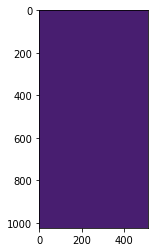

In [9]:
heatmap_loc = PATH+'/train/normal100heatmap.npy'
heatmap = np.load(heatmap_loc)
print(heatmap.shape)
plt.figure()
plt.imshow(heatmap[:, :, 0])
print(np.sum(heatmap[:, :, 1]))

-23656067.25575803


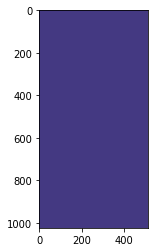

In [20]:
heatmap_loc = PATH+'/train/normal26heatmap.npy'
heatmap = np.load(heatmap_loc)
plt.figure()
heatmap = heatmap+np.amin(heatmap)
heatmap = 255*(heatmap/np.amax(heatmap))
plt.imshow(heatmap[:, :, 0])
print(np.sum(heatmap[:, :, :]))